## How to run experiments to compare QS and IH?

Based on the work:

"Towards a more accurate quasi-static approximation of the electric potential for neurostimulation with kilohertz-frequency sources" for explanations."

Authors: Thomas Caussade, Esteban Paduro, Matías Courdurier, Eduardo Cerpa, Warren M. Grill, Leonel E. Medina


First, we import all relevant needed functionalities

In [1]:
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import time as time

from inh_src.functionalities import *

### This is the same than running:
# from inh_src.Tissue import Tissue
# from inh_src.ElectricPotential import ElectricPotential
# from inh_src.Experiment import Experiment
# from inh_src.NeuralResponse import FiberConstructor, NeuronExperiment


### Select the (dispersive) media
Tissue.py creates an object containing all neccesary data to compute the required permitivitties and conductivities, using the multiple Cole-Cole model proposed by Gabriel.

To add new tissues, you should look for the tables in the original reference and copy the necessary parameters.

Currently available tissues are: brain grey matter, white matter, liver, bone, fat, muscle and skin. 

In [2]:
# Select Media #
tissue_type = "brain_grey"
TISSUE = Tissue(tissue_type)

### Define the experiment and source parameters

In [3]:
# Point-source stimulation parameters
source_params = {"forma": "biphasic_train", # waveform 
                "amp": 0.5,  # stimulation amplitude (mA)
                "ps": 10,     # begin stimulation (ms)
                "pw": 0.01,   # pulse duration (ms) 
                "ftrain": .1, # frequency of repetition (kHz)
                "tend": 15,   # end experiment (ms)
                "npulses": 1, # number of pulses
                "loc": np.array([0.,1,0.]), # electrode-to-fiber distance (mm)
                "pol": -1}    # polarity (first-phase anodic or cathodic)

# Select electric model
electric_model = "QS" 

# Construct the source
elec  = ElectricPotential(source_params, electric_model)

# simulation parameters
simulation_params = {"fcutoff" : 500.0, # Maximal frequency content (kHz)
                     "pp" : 20}         # Points to sample the highest frequency

# Construct the experiment
EXP = Experiment(simulation_params)
EXP.dt = 1e-6 # You can set the time step in this manner


### Compute the electric potential

To apply the stimulation to the fiber, you must join the generated potential (array) and its data (dict) as a tuple.

In [4]:
# Time grid
t     = EXP.timegrid([elec])

# Compute the generated potential 
sqs   = 0.105 # Quasi-static conductivity (only required if electric_model == "QS")
pot   = EXP.compute_potential(t,elec, TISSUE, sigma_qs = sqs)

# Join the potential and its data
elec1 = (elec,pot)


 Computing QS electric potential
Conductivity: 0.105 [S/m]


### Construct the MRG model fiber

You can provide all necesarry parameters here. The model is assembled using Neuron capabilities.

In [5]:
# create fiber #
fiber_params = {"constant_cm" : 0,
                "c_dc" : 1.0,
                "is_xtra" : 1,
                "intra_node" : 0,
                "fiberD" : 16.0,
                "nnodes" : 84}
FIBER = FiberConstructor(fiber_params).assign_fiber_model("MRG")

NEURON: Couldn't find: nrnfiberlib/fiber_library.hoc
 near line 0
 objref hoc_obj_[2]
                   ^


AttributeError: 'hoc.HocObject' object has no attribute 'MRGFiber'

### Run Neuron!
Set the necessary parameters in Neuron and run the neural simulation.

Applying extracellular potential...
Running neuron!
Time elapsed [s]: 23.376750707626343


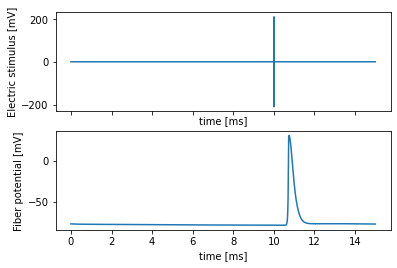

In [ ]:
# neuron parameters
h_params = {"temperature": 37, # Celsius
            "v_init" : -77.3,  # [mV]
            "tend" : source_params["tend"],
            "cvode": 0}

# Run simulation!
tr0 = time.time()
th, output  = NeuronExperiment(h_params).run_neuron(FIBER,t*1e3,(elec1,))
print("Time elapsed [s]:", time.time()-tr0 )

# Show the applied potential (output["ex"]) and voltage in the end of the fiber (output["ve"])
fig,ax = plt.subplots(2,1, sharex = True)
ax[0].plot(th, output["ex"], label = "neuron")
ax[0].set_xlabel("time [ms]")
ax[0].set_ylabel("Electric stimulus [mV]")
ax[1].plot(th, output["ve"])
ax[1].set_xlabel("time [ms]")
ax[1].set_ylabel("Fiber potential [mV]")

plt.show()
